In [1]:
import geopandas as gpd
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
import libpysal

In [2]:
file_path = "../data/data_cleaned/"
graph_file_path = f"{file_path}singapore_walk_graph.graphml"
nodes_file_path  = f"{file_path}singapore_walk_graph_nodes.geojson"
edges_file_path  = f"{file_path}singapore_walk_graph_edges.geojson"

In [3]:
# CONSTANTS
CRS_PROJ = "EPSG:3414"  # Singapore SVY21
DISTANCE_THRESHOLD = 1600  # 1.5km max walking distance (~20 mins)

# Load pre-saved projected graph and GeoJSONs
G_proj = ox.load_graphml(graph_file_path)
G_nodes_proj = gpd.read_file(nodes_file_path)
G_edges_proj = gpd.read_file(edges_file_path)

# Project Graph to Meters only if needed
graph_crs = G_proj.graph.get("crs")
if graph_crs is None or str(graph_crs) != CRS_PROJ:
    G_proj = ox.project_graph(G_proj, to_crs=CRS_PROJ)

Skipping field highway: unsupported OGR type: 5
Skipping field lanes: unsupported OGR type: 5
Skipping field maxspeed: unsupported OGR type: 5
Skipping field name: unsupported OGR type: 5
Skipping field access: unsupported OGR type: 5
Skipping field service: unsupported OGR type: 5
Skipping field tunnel: unsupported OGR type: 5
Skipping field bridge: unsupported OGR type: 5
Skipping field width: unsupported OGR type: 5
Skipping field est_width: unsupported OGR type: 5


In [4]:
raw_path = "../data/data_raw/"

In [5]:
hdb_population = 3190590
hdb_unit_num = 1153080

planning_area = gpd.read_file(f"{raw_path}MasterPlan2019PlanningAreaBoundaryNoSea.geojson")
subzone = gpd.read_file(f"{raw_path}MasterPlan2019SubzoneBoundaryNoSeaGEOJSON.geojson")
sport_facilities  = gpd.read_file(f"{raw_path}SportSGSportFacilitiesGEOJSON.geojson")
parks = gpd.read_file(f"{raw_path}NParksParksandNatureReserves.geojson")
park_connector = gpd.read_file(f"{raw_path}ParkConnectorLoop.geojson")
cycling_paths = gpd.read_file(f"{raw_path}CyclingPathNetwork.geojson")
hdb = gpd.read_file(f"{raw_path}HDBExistingBuilding.geojson")

In [6]:
planning_area = planning_area.to_crs(CRS_PROJ)
subzone = subzone.to_crs(CRS_PROJ)
sport_facilities = sport_facilities.to_crs(CRS_PROJ)
park_connector = park_connector.to_crs(CRS_PROJ)
parks = parks.to_crs(CRS_PROJ)
cycling_paths = cycling_paths.to_crs(CRS_PROJ)
hdb = hdb.to_crs(CRS_PROJ)

In [7]:
# Count number of HDB buildings
hdb_num = len(hdb)
hdb_population_per_block = hdb_population / hdb_num
hdb_population_per_unit = hdb_population / hdb_unit_num

print(f"Number of HDB buildings: {hdb_num}")
print(f"Rough estimation of population per HDB block: {hdb_population_per_block}")
print(f"Number of HDB units: {hdb_unit_num}")
print(f"Rough estimation of population per HDB unit: {hdb_population_per_unit}")

Number of HDB buildings: 13160
Rough estimation of population per HDB block: 242.44604863221883
Number of HDB units: 1153080
Rough estimation of population per HDB unit: 2.7670152981579768


In [8]:
# Add population column to HDB geodataframe (per-block estimate)
hdb['population'] = hdb_population_per_block
hdb.head()

,name,geometry,population
0,Path,"LINESTRING (24481.043 47869.63, 24480.427 4786...",242.446049
1,Path,"LINESTRING (18753.211 37893.756, 18764.786 379...",242.446049
2,Path,"LINESTRING (41887.998 37282.122, 41889.532 372...",242.446049
3,Path,"LINESTRING (18696.214 41806.326, 18691.537 418...",242.446049
4,Path,"LINESTRING (26218.761 29036.217, 26222.34 2904...",242.446049


In [9]:
def facility_preprocessing(gdf_facilities):
    """
    Prepares SportSG Facilities Data.
    """
    # Ensure CRS
    gdf_facilities = gdf_facilities.to_crs(CRS_PROJ)
    
    # Change the geometry from polygon Z to point (centroid )
    gdf_facilities['geometry'] = gdf_facilities.geometry.centroid
    
    # Assign ID
    gdf_facilities['facility_id'] = range(len(gdf_facilities))
    
    # Ensure we have a capacity column (Supply). 
    # Since floor area is not available, we'll assume 1
    if 'capacity' not in gdf_facilities.columns:
        gdf_facilities['capacity'] = 1
        
    return gdf_facilities

In [10]:
def population_preprocessing(gdf_pop):
    """
    Prepares HDB Population Data.
    """
    # Ensure CRS
    gdf_pop = gdf_pop.to_crs(CRS_PROJ)
    
    # Ensure we have centroids
    gdf_pop['centroid'] = gdf_pop.geometry.centroid
    
    # Assign ID
    gdf_pop['pop_id'] = range(len(gdf_pop))
    
    # Create a buffer for the "Euclidean Filter" step later
    gdf_pop['search_buffer'] = gdf_pop['centroid'].buffer(DISTANCE_THRESHOLD)
    
    return gdf_pop

In [11]:
def _get_nearest_nodes(gdf, G_proj, geometry, column_name = 'node_id'):
    gdf = ox.nearest_nodes(G_proj, geometry.x, geometry.y)
    gdf_pop[column_name] = pop_nodes

In [12]:
def _get_index_within_distance(gdf_demand, gdf_supply):
    """
    Only remain demand data that's within
    supply's buffer zone
    """
    tmp = gpd.sjoin(
        gdf_supply, 
        gpd.GeoDataFrame(gdf_demand[['pop_id', 'search_buffer']], geometry='search_buffer'), 
        how='inner', 
        predicate='within'
    )

    return tmp


In [13]:
def get_network_distances(gdf_pop, gdf_facilities, G_proj):
    """
    Calculates network distance between Pop and Facilities
    ONLY if they are within the Euclidean buffer (Optimization).
    """
    
    # 1. Pre-filter: Find pairs that are geographically close (Vectorized)
    # This prevents calculating network paths for Punggol -> Jurong (waste of time)
    joined = gpd.sjoin(
        gdf_facilities, 
        gpd.GeoDataFrame(gdf_pop[['pop_id', 'search_buffer']], geometry='search_buffer'), 
        how='inner', 
        predicate='within'
    )
    # _get_index_within_distance(gdf_pop, gdf_facilities)
    
    print("join")
    display(joined.head())


    # 2. Get Nearest Network Nodes
    # To speed this up, calculating nodes for unique points only
    
    # For Population
    pop_nodes = ox.nearest_nodes(G_proj, gdf_pop.centroid.x, gdf_pop.centroid.y)
    gdf_pop['origin_node'] = pop_nodes
    # _get_nearest_nodes(gdf_pop, G_proj, gdf_pop.centroid, column_name='origin_node')
    
    # For Facilities
    fac_nodes = ox.nearest_nodes(G_proj, gdf_facilities.geometry.x, gdf_facilities.geometry.y)
    gdf_facilities['dest_node'] = fac_nodes
    # _get_nearest_nodes(gdf_facilities, G_proj, gdf_pop.geometry, column_name=''dest_node')

    # Merge Node IDs into the pair list
    pairs = joined.merge(gdf_pop[['pop_id', 'origin_node', 'population']], on='pop_id', how='left')
    pairs = pairs.merge(
        gdf_facilities[['facility_id', 'dest_node', 'capacity']],
        on='facility_id',
        how='left',
        suffixes=("_x", "_y")
    )
    
    print("pairs")
    display(pairs.head())

    # Normalize column names to avoid dest_node_x/dest_node_y conflicts
    if 'dest_node' not in pairs.columns:
        if 'dest_node_y' in pairs.columns:
            pairs.rename(columns={'dest_node_y': 'dest_node'}, inplace=True)
        elif 'dest_node_x' in pairs.columns:
            pairs.rename(columns={'dest_node_x': 'dest_node'}, inplace=True)
    if 'capacity' not in pairs.columns:
        if 'capacity_y' in pairs.columns:
            pairs.rename(columns={'capacity_y': 'capacity'}, inplace=True)
        elif 'capacity_x' in pairs.columns:
            pairs.rename(columns={'capacity_x': 'capacity'}, inplace=True)

    # 3. Calculate Shortest Path (The Heavy Lifting)
    # Using NetworkX bi-directional dijkstra (fastest for 1-to-1)
    results = []
    
    for idx, row in pairs.iterrows():
        try:
            dist = nx.shortest_path_length(
                G_proj, 
                source=row['origin_node'], 
                target=row['dest_node'], 
                weight='length'
            )
            
            # Only keep if within threshold
            if dist <= DISTANCE_THRESHOLD:
                results.append({
                    'pop_id': row['pop_id'],
                    'facility_id': row['facility_id'],
                    'distance': dist,
                    'pop_demand': row['population'],
                    'facility_supply': row['capacity']
                })
        except nx.NetworkXNoPath:
            continue
    result = pd.DataFrame(results)

    print("result")
    display(result.head())

    return result

In [14]:
def calculate_m2sfca(df_od, distance_threshold):
    """
    Calculate accessibility scores
    """
    
    # --- Gaussian Decay Function ---
    # As distance increases, weight drops.
    # At 0m, weight = 1. At Threshold, weight approaches 0.
    v = -distance_threshold**2 / np.log(0.01) # 0.01 is the weight at the limit
    df_od['weight'] = np.exp(-(df_od['distance'])**2 / v)
    
    # --- Step 1: Supply-to-Demand Ratio (Rj) ---
    # How crowded is the facility?
    
    # Weighted Demand: Pop * DistanceWeight
    df_od['weighted_demand'] = df_od['pop_demand'] * df_od['weight']
    
    # Sum of weighted demand per Facility
    facility_demand_sum = df_od.groupby('facility_id')['weighted_demand'].sum().reset_index()
    facility_demand_sum.rename(columns={'weighted_demand': 'total_demand_at_facility'}, inplace=True)
    
    # Merge back
    df_od = df_od.merge(facility_demand_sum, on='facility_id')
    
    # Calculate Ratio Rj = Supply / Total Weighted Demand
    df_od['Rj'] = df_od['facility_supply'] / df_od['total_demand_at_facility']
    
    # --- Step 2: Accessibility Score (Ai) ---
    # Sum the ratios available to each resident
    
    # Weighted Ratio: Rj * DistanceWeight
    df_od['weighted_Rj'] = df_od['Rj'] * df_od['weight']
    
    # Sum per Population Point
    accessibility_scores = df_od.groupby('pop_id')['weighted_Rj'].sum().reset_index()
    accessibility_scores.rename(columns={'weighted_Rj': '2sfca_score'}, inplace=True)
    
    return accessibility_scores

In [15]:
# 2. Preprocess
hdb = population_preprocessing(hdb)
sport_facilities = facility_preprocessing(sport_facilities)

In [16]:
hdb.head()

,name,geometry,population,centroid,pop_id,search_buffer
0,Path,"LINESTRING (24481.043 47869.63, 24480.427 4786...",242.446049,POINT (24457.667 47865.143),0,"POLYGON ((26057.667 47865.143, 26049.962 47708..."
1,Path,"LINESTRING (18753.211 37893.756, 18764.786 379...",242.446049,POINT (18772.678 37887.871),1,"POLYGON ((20372.678 37887.871, 20364.973 37731..."
2,Path,"LINESTRING (41887.998 37282.122, 41889.532 372...",242.446049,POINT (41907.212 37272.926),2,"POLYGON ((43507.212 37272.926, 43499.507 37116..."
3,Path,"LINESTRING (18696.214 41806.326, 18691.537 418...",242.446049,POINT (18723.768 41826.052),3,"POLYGON ((20323.768 41826.052, 20316.064 41669..."
4,Path,"LINESTRING (26218.761 29036.217, 26222.34 2904...",242.446049,POINT (26245.512 29051.375),4,"POLYGON ((27845.512 29051.375, 27837.808 28894..."


In [17]:
sport_facilities.head()

,Name,Description,geometry,facility_id,capacity
0,kml_1,<center><table><tr><th colspan='2' align='cent...,POINT (20170.668 32446.744),0,1
1,kml_2,<center><table><tr><th colspan='2' align='cent...,POINT (20450.387 32532.653),1,1
2,kml_3,<center><table><tr><th colspan='2' align='cent...,POINT (12544.661 35609.322),2,1
3,kml_4,<center><table><tr><th colspan='2' align='cent...,POINT (32351.913 33877.383),3,1
4,kml_5,<center><table><tr><th colspan='2' align='cent...,POINT (33033.718 32012.926),4,1


In [18]:
# 3. Calculate Network Distances (The Slow Part)
df_od_pairs = get_network_distances(hdb, sport_facilities, G_proj)

join


,Name,Description,geometry,facility_id,capacity,index_right,pop_id
0,kml_1,<center><table><tr><th colspan='2' align='cent...,POINT (20170.668 32446.744),0,1,61,61
0,kml_1,<center><table><tr><th colspan='2' align='cent...,POINT (20170.668 32446.744),0,1,110,110
0,kml_1,<center><table><tr><th colspan='2' align='cent...,POINT (20170.668 32446.744),0,1,124,124
0,kml_1,<center><table><tr><th colspan='2' align='cent...,POINT (20170.668 32446.744),0,1,172,172
0,kml_1,<center><table><tr><th colspan='2' align='cent...,POINT (20170.668 32446.744),0,1,182,182


pairs


,Name,Description,geometry,facility_id,capacity_x,index_right,pop_id,origin_node,population,dest_node,capacity_y
0,kml_1,<center><table><tr><th colspan='2' align='cent...,POINT (20170.668 32446.744),0,1,61,61,12238577935,242.446049,6224254718,1
1,kml_1,<center><table><tr><th colspan='2' align='cent...,POINT (20170.668 32446.744),0,1,110,110,12471083155,242.446049,6224254718,1
2,kml_1,<center><table><tr><th colspan='2' align='cent...,POINT (20170.668 32446.744),0,1,124,124,8344442001,242.446049,6224254718,1
3,kml_1,<center><table><tr><th colspan='2' align='cent...,POINT (20170.668 32446.744),0,1,172,172,12395682878,242.446049,6224254718,1
4,kml_1,<center><table><tr><th colspan='2' align='cent...,POINT (20170.668 32446.744),0,1,182,182,2391178699,242.446049,6224254718,1


result


,pop_id,facility_id,distance,pop_demand,facility_supply
0,124,0,605.493980,242.446049,1
1,182,0,781.399035,242.446049,1
2,201,0,879.131742,242.446049,1
3,210,0,1384.122847,242.446049,1
4,218,0,949.978133,242.446049,1


In [19]:
# 4. Compute Score
final_scores = calculate_m2sfca(df_od_pairs, DISTANCE_THRESHOLD)

<Axes: >

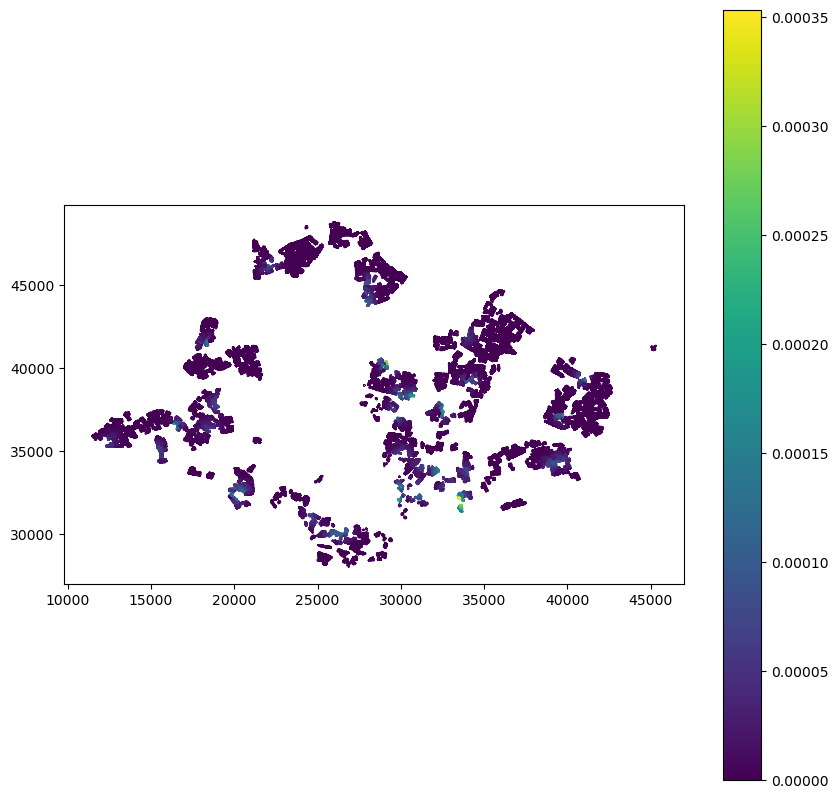

In [20]:
# 5. Merge back to Map
final_map = hdb.merge(final_scores, on='pop_id', how='left')

# Fill NaN with 0 (areas with NO access)
final_map['2sfca_score'] = final_map['2sfca_score'].fillna(0)

# 6. Visualize
final_map.plot(column='2sfca_score', legend=True, cmap='viridis', figsize=(10, 10))

In [ ]:
# 7. Export GeoDataFrame to GeoJSON (WGS84)
from pathlib import Path

# Prepare a copy with only one geometry column
final_map_export = final_map.copy()
active_geom_name = final_map_export.geometry.name
extra_geom_cols = [c for c, dt in final_map_export.dtypes.items() if dt == "geometry" and c != active_geom_name]
if extra_geom_cols:
    final_map_export = final_map_export.drop(columns=extra_geom_cols)

# Reproject to WGS84 for GeoJSON/web mapping
# GeoJSON (RFC 7946) requires WGS84 coordinates (EPSG:4326) in degrees; other CRSs are not allowed in the spec.
# Web compatibility: Web map libraries (Leaflet, Mapbox GL, deck.gl) expect lon/lat GeoJSON; EPSG:3414 will render in the wrong place or be rejected
final_map_wgs84 = final_map_export.to_crs("EPSG:4326")

# Define output path
output_path = "../data/data_cleaned/sportSG_2sfca.geojson"
Path(Path(output_path).parent).mkdir(parents=True, exist_ok=True)

# Save to GeoJSON
final_map_wgs84.to_file(output_path, driver="GeoJSON")
print(f"GeoJSON saved to: {output_path}")

GeoJSON saved to: ../data/data_cleaned/sportSG_2sfca.geojson


: 

In [ ]:
G_nodes_proj, G_edges_proj = ox.graph_to_gdfs(G_proj, nodes=True, edges=True)
edges = G_edges_proj.union_all()

In [ ]:
def parks_preprocessing(gdf_parks, destination='Entrance', min_separation=50, snap_buffer=20, dedup_buffer=25):
    """
    Prepare Parks polygons for network-based accessibility:
    - Ensure projected CRS (meters)
    - Validate/fix geometries and keep valid areas
    - Compute area (sqm, ha) as a proxy for supply
    - Optionally convert to entrance points by intersecting park perimeters with road edges
    - Add identifiers and return a proper GeoDataFrame with active geometry

    Parameters
    ----------
    gdf_parks : GeoDataFrame (polygons)
    destination : {'Entrance', 'centroid'}
        - 'Entrance': derive access points along park boundaries where they touch network edges
        - 'centroid': use polygon centroids as access points
    min_separation : float (meters)
        Minimum distance for de-duplicating nearby entrances (used via component labeling)
    snap_buffer : float (meters)
        Buffer distance around park polygons to find nearby network edges for entrance creation
    dedup_buffer : float (meters)
        Buffer used to group nearby entrances for de-duplication
    """
    # Ensure CRS
    gdf_parks = gdf_parks.to_crs(CRS_PROJ)

    # Drop empties and fix invalid geometries (buffer(0) trick)
    gdf_parks = gdf_parks[gdf_parks.geometry.notna() & ~gdf_parks.geometry.is_empty]
    gdf_parks["geometry"] = gdf_parks.buffer(0)

    # Keep polygonal geometries only
    gdf_parks = gdf_parks[gdf_parks.geometry.geom_type.isin(["Polygon", "MultiPolygon"])]

    # Compute area (projected CRS ensures meters)
    gdf_parks["area"] = gdf_parks.geometry.area
    gdf_parks = gdf_parks[gdf_parks["area"] > 0]

    # Precompute centroids (useful for fallback or centroid option)
    gdf_parks["centroid"] = gdf_parks.geometry.centroid

    # Assign a stable park_id
    gdf_parks = gdf_parks.reset_index(drop=True)
    gdf_parks["park_id"] = np.arange(len(gdf_parks))

    green_access = None

    # Case 1: Use centroids directly
    if str(destination).lower() == 'centroid':
        ga = gdf_parks[["centroid", "area", "park_id"]].rename(columns={"centroid": "geometry"}).copy()
        green_access = gpd.GeoDataFrame(ga, geometry="geometry", crs=CRS_PROJ)
    # Case 2: Derive entrances from boundary-edge intersections
    else:
        entrance_points = []
        # Buffer the park polygons slightly to capture nearby network edges
        gdf_parks["_buffer"] = gdf_parks.geometry.buffer(snap_buffer)

        for i, row in gdf_parks.iterrows():
            green_area = row["geometry"].area
            inter = row["_buffer"].boundary.intersection(edges)
            if inter.is_empty:
                continue
            # Collect point geometries from intersection results
            if hasattr(inter, "geoms"):
                pts = [g for g in inter.geoms if g.geom_type == "Point"]
            elif inter.geom_type == "Point":
                pts = [inter]
            else:
                pts = []
            for p in pts:
                entrance_points.append({"geometry": p, "area": green_area, "park_id": row["park_id"]})

        # Build GeoDataFrame from entrances or fallback to centroids if none found
        if len(entrance_points) == 0:
            # Fallback: use centroids to avoid empty result and downstream KeyError
            ga = gdf_parks[["centroid", "area", "park_id"]].rename(columns={"centroid": "geometry"}).copy()
            green_access = gpd.GeoDataFrame(ga, geometry="geometry", crs=CRS_PROJ)
        else:
            green_access = gpd.GeoDataFrame(entrance_points, geometry="geometry", crs=CRS_PROJ)

        # De-duplicate entrances closer than dedup_buffer via fuzzy contiguity components
        if len(green_access) > 0:
            green_access["_dedup_buf"] = green_access.geometry.buffer(dedup_buffer)
            w_e = libpysal.weights.fuzzy_contiguity(green_access["_dedup_buf"]) if len(green_access) > 0 else None
            if w_e is not None:
                green_access["entrance_components"] = w_e.component_labels
                green_access = green_access.drop_duplicates(subset=["entrance_components"], keep='first').reset_index(drop=True)
            if "_dedup_buf" in green_access:
                green_access = green_access.drop(columns=["_dedup_buf"])  # cleanup helper
        if "_buffer" in gdf_parks:
            gdf_parks = gdf_parks.drop(columns=["_buffer"])  # cleanup helper

    # If still empty (edge case), return an empty but well-formed GeoDataFrame
    if green_access is None or len(green_access) == 0:
        return gpd.GeoDataFrame(columns=["geometry", "area", "park_id", "facility_id", "capacity"], geometry="geometry", crs=CRS_PROJ)

    # Ensure required columns for downstream functions
    green_access = green_access.reset_index(drop=True)
    # Each access point acts as a facility
    green_access["facility_id"] = np.arange(len(green_access))
    # Use park area as supply proxy; for multiple entrances per park, distribute area evenly
    if "park_id" in green_access.columns:
        counts = green_access.groupby("park_id")["park_id"].transform("count")
        green_access["capacity"] = green_access["area"] / counts
    else:
        green_access["capacity"] = green_access["area"]

    return green_access

In [ ]:
parks.head()

In [ ]:
green_access = parks_preprocessing(parks)
green_access.head()

In [ ]:
df_od_pairs = get_network_distances(hdb, green_access, G_proj)

In [ ]:
final_scores = calculate_m2sfca(df_od_pairs, DISTANCE_THRESHOLD)


In [ ]:
final_map = hdb.merge(final_scores, on='pop_id', how='left')


In [ ]:
final_map['2sfca_score'] = final_map['2sfca_score'].fillna(0)
final_map.plot(column='2sfca_score', legend=True, cmap='viridis', figsize=(10, 10))